In [7]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

from qmc_sampler import *

In [9]:
qmc = qmcSampler(generator = HaltonGenerator, d = 2, randomize = False)

In [10]:
def FtnOblate(theta_p, ratio):
    coeff = -.5*ratio
    term1 = np.arcsinh(np.sqrt(-1+ratio**2)*np.sin(theta_p))/np.sqrt(-1+ratio**2)
    term2 = np.sin(theta_p)*np.sqrt(1+(-1+ratio**2)*np.sin(theta_p)**2)
    return coeff*(term1+term2)

In [11]:
def FtnOblateNormalized(theta_p, ratio):
    return FtnOblate(theta_p, ratio)/FtnOblate(np.pi/2, ratio)

In [12]:
def FtnSpheroid(theta_p, ratio):
    coeff = -.5*ratio
    term2 = np.sin(theta_p)*np.sqrt(1+(-1+ratio**2)*np.sin(theta_p)**2)
    if ratio > 1:
        term1 = np.arcsinh(np.sqrt(-1+ratio**2)*np.sin(theta_p))/np.sqrt(-1+ratio**2)
        return coeff*(term1+term2)
    
    if ratio < 1:
        term1 = np.arcsin(np.sqrt(1-ratio**2)*np.sin(theta_p))/np.sqrt(1-ratio**2)
        return coeff*(term1+term2)
    
    if ratio == 1:
        return np.sin(theta_p)
    

In [13]:
def FtnSpheroidNormalized(theta_p, ratio):
    return FtnSpheroid(theta_p, ratio)/FtnSpheroid(np.pi/2, ratio)

In [14]:
def ToPolarAngle(u, ratio):
    return root(fun = lambda var_theta_p: FtnSpheroidNormalized(var_theta_p, ratio) - u, x0 = 0).x

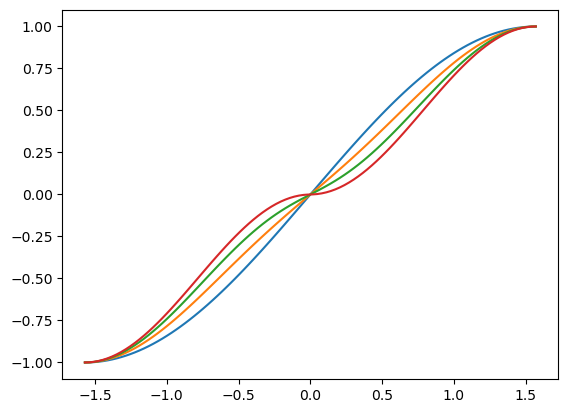

In [15]:
arr_theta = np.linspace(-np.pi/2,np.pi/2,100)
ratio_list = [1,2,4,100]
for ratio in ratio_list:
    plt.plot(arr_theta,FtnSpheroidNormalized(arr_theta,ratio))

1
0.5
0.25
0.01


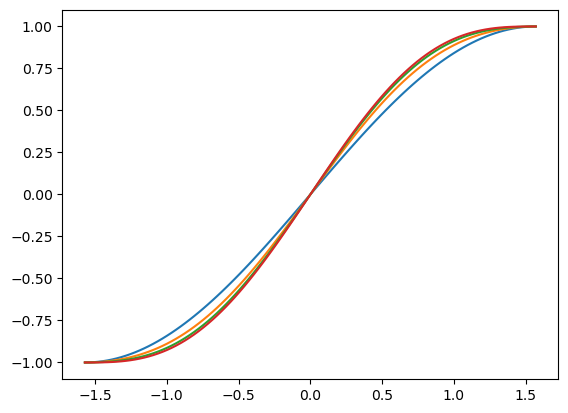

In [16]:
arr_theta = np.linspace(-np.pi/2,np.pi/2,100)
ratio_list = [1,1/2,1/4,1/100]
for ratio in ratio_list:
    print(ratio)
    plt.plot(arr_theta,FtnSpheroidNormalized(arr_theta,ratio))

In [17]:
nsamples=1000
a = 2.
b = 4.
ratio = b/a

In [18]:
u_list = 2*qmc.sampleUniform(nsamples)[:,0]-1
phi_list = 2*np.pi*qmc.sampleUniform(nsamples)[:,1]
theta_list = np.array([ToPolarAngle(u,ratio=ratio)+np.pi/2 for u in u_list]).ravel()


In [19]:
x = b*np.sin(theta_list)*np.cos(phi_list)
y = b*np.sin(theta_list)*np.sin(phi_list)
z = a*np.cos(theta_list)

<IPython.core.display.Javascript object>


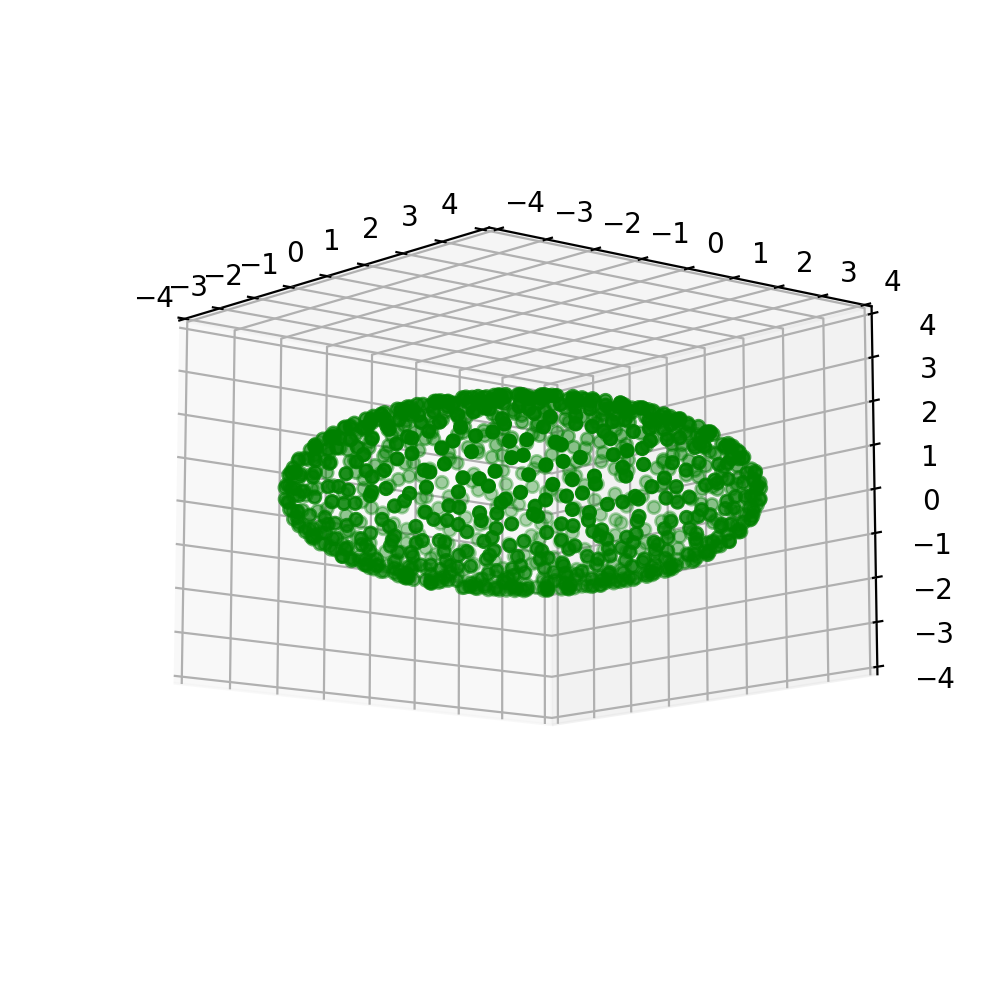

In [20]:
%matplotlib notebook
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize = (5, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "green")
ax.set_xlim((-max(a,b),max(a,b)))
ax.set_ylim((-max(a,b),max(a,b)))
ax.set_zlim((-max(a,b),max(a,b)))

# show plot
plt.show()

<IPython.core.display.Javascript object>


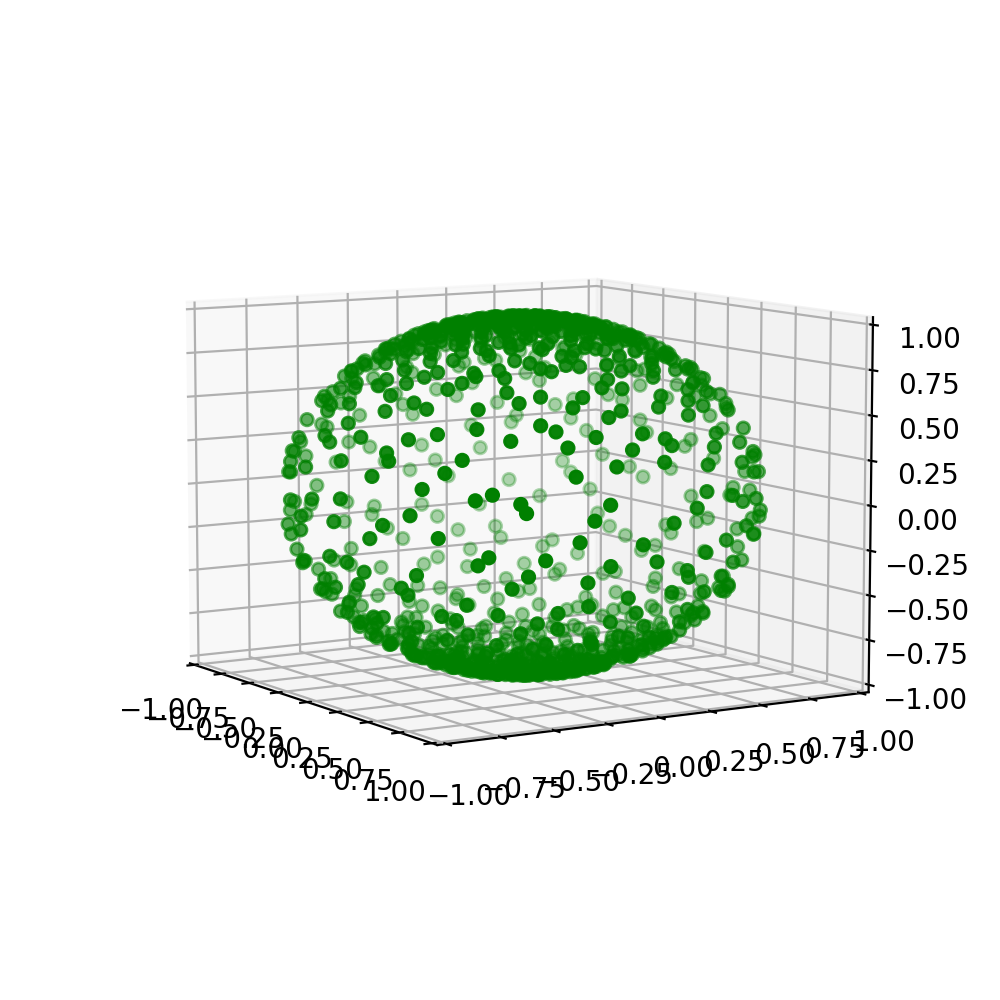

In [21]:
%matplotlib notebook
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize = (5, 5))
ax = plt.axes(projection ="3d")

radii = np.sqrt(x**2+y**2+z**2)
arr_ellipsoid_QMC = np.vstack((x.T,y.T,z.T)).T
arr_r_axis = np.array([b,b,a],dtype=arr_ellipsoid_QMC.dtype)
arr_normal_QMC = arr_ellipsoid_QMC / arr_r_axis**2
arr_normal_QMC = arr_normal_QMC / np.linalg.norm(arr_normal_QMC, axis=-1)[:,np.newaxis]

# Creating plot
ax.scatter3D(arr_normal_QMC[:,0], arr_normal_QMC[:,1], arr_normal_QMC[:,2], color = "green")
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-1,1))

# show plot
plt.show()

In [22]:

def sample_unit_sphere(n_sample):
    '''  
    Generate n_sample position vectors

    Parameters
    ----------
    n_sample : integer
        number of stars to be generated

    Returns
    -------
    np.array with shape (n_star, 3)
        array contains (x,y,z) vector of each star

    '''
    nparray_u = np.random.uniform(0, 1, size=(n_sample,))
    nparray_v = np.random.uniform(0, 1, size=(n_sample,))
        
    # polar angle
    nparray_phi   = 2. * np.pi * nparray_u
    nparray_sin_phi = np.sin(nparray_phi)
    nparray_cos_phi = np.cos(nparray_phi)

    # azimuth angle
    nparray_cos_theta = 2.*nparray_v - 1.
    nparray_theta = np.arccos(nparray_cos_theta)
    nparray_sin_theta = np.sin(nparray_theta)

    # radial unit vector
    nparray_rhat = np.column_stack((
        nparray_cos_phi * nparray_sin_theta,
        nparray_sin_phi * nparray_sin_theta,
        nparray_cos_theta
    ))

    return nparray_rhat


In [23]:

def sample_ellipsoid(n_sample, ra, rb, rc, multiplier=1.5):
    area_ratio_max = max(ra*rb, rb*rc, rc*ra)
    area_ratio_min = min(ra*rb, rb*rc, rc*ra)

    rejection_prob_min = area_ratio_min / area_ratio_max

    n_sample_gen = int(n_sample / rejection_prob_min * multiplier)
    print(n_sample_gen)
    
    arr_sphere = sample_unit_sphere(n_sample_gen)
    arr_area_ratio = np.sqrt(
        (arr_sphere[:,0]*rb*rc)**2
        + (ra*arr_sphere[:,1]*rc)**2
        + (ra*rb*arr_sphere[:,2])**2
    )
    arr_draw = np.random.random_sample(arr_sphere.shape[0])
    arr_mask = arr_draw < arr_area_ratio / area_ratio_max
    
    # rejection sampling
    arr_sphere = arr_sphere[arr_mask]
    print(arr_sphere.shape)
    if arr_sphere.shape[0] < n_sample:
        print("WARNING: rejection sampling fails to generate {} samples. Please increase multiplier.".format(n_sample))
    else:
        arr_sphere = arr_sphere[:n_sample]

    # coordinate transformation to ellipsoid
    arr_r_axis = np.array([ra,rb,rc],dtype=arr_sphere.dtype)
    arr_ellipsoid = arr_sphere * arr_r_axis

    print(np.amax(arr_ellipsoid,axis=0))
    print(np.amin(arr_ellipsoid,axis=0))

    # normal 
    arr_normal = arr_ellipsoid / arr_r_axis**2
    arr_normal = arr_normal / np.linalg.norm(arr_normal, axis=-1)[:,np.newaxis]
    #print(arr_ellipsoid[:2])
    #print(arr_normal[:2])
    return arr_ellipsoid, arr_normal
   

In [24]:
arr_ellipse, arr_normal = sample_ellipsoid(1000,4,4,2)

3000
(2058, 3)
[3.98569466 3.97597277 1.99554007]
[-3.99783876 -3.9869003  -1.99641774]


<IPython.core.display.Javascript object>


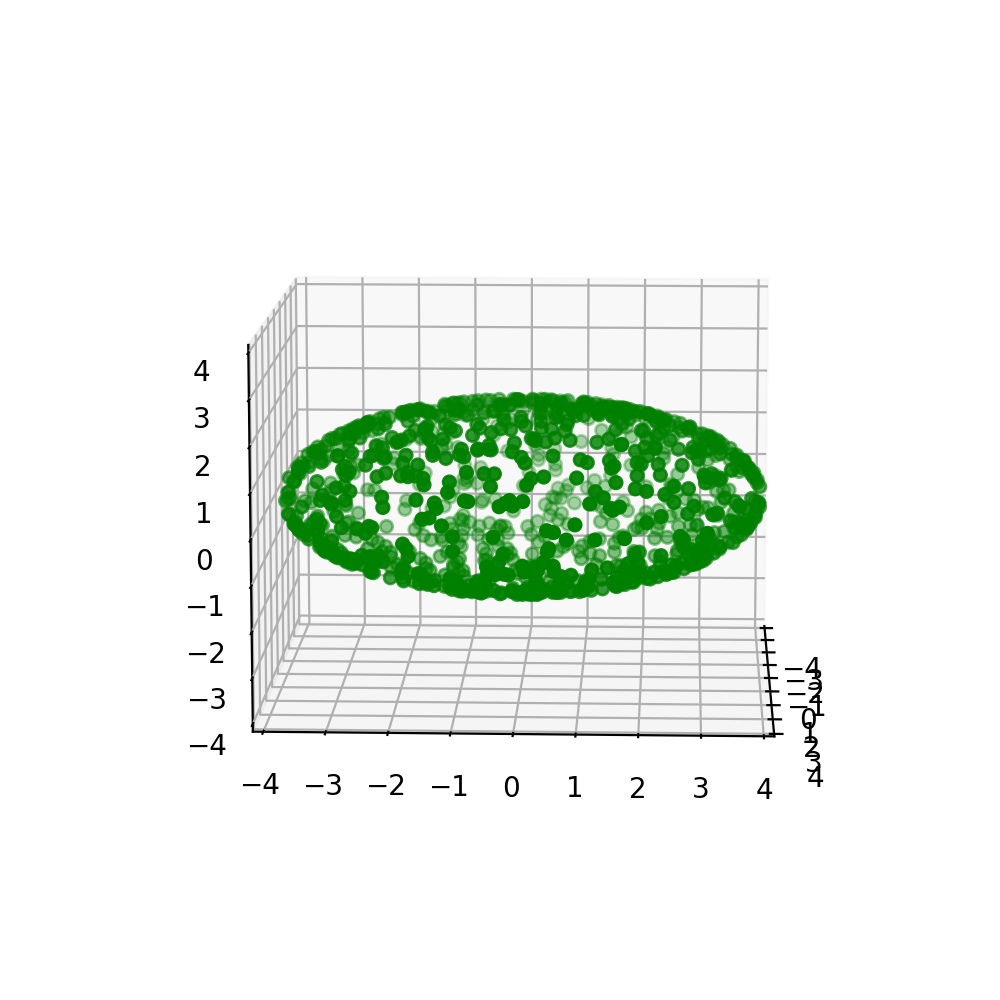

In [25]:
%matplotlib notebook
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize = (5, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(arr_ellipse[:,0], arr_ellipse[:,1], arr_ellipse[:,2], color = "green")
ax.set_xlim((-max(a,b),max(a,b)))
ax.set_ylim((-max(a,b),max(a,b)))
ax.set_zlim((-max(a,b),max(a,b)))

# show plot
plt.show()

<IPython.core.display.Javascript object>


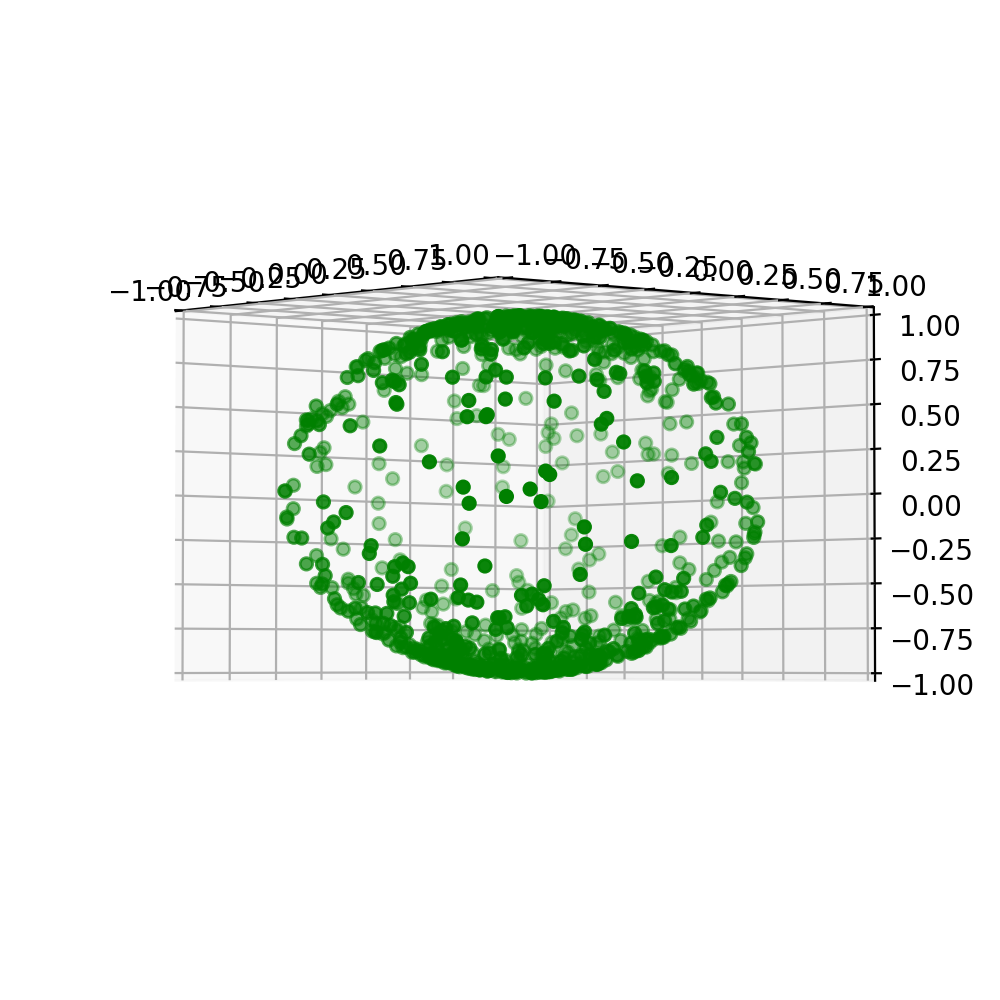

In [26]:
%matplotlib notebook
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize = (5, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(arr_normal[:,0], arr_normal[:,1], arr_normal[:,2], color = "green")
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-1,1))

# show plot
plt.show()

In [27]:
np.linalg.norm(arr_normal,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [57]:
ABC=2

In [59]:
def testfcn():
    return ABC

In [61]:
testfcn()

2